# Ridge and Lasso Regression

Syed Hussain Ather

(from https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/)

## Overview:
+ Ridge Regression:
+ + Performs L2 regularization, i.e. adds penalty equivalent to square of the magnitude of coefficients
+ + Minimization objective = LS Obj + α * (sum of square of coefficients)
+ Lasso Regression:
+ + Performs L1 regularization, i.e. adds penalty equivalent to absolute value of the magnitude of coefficients
+ + Minimization objective = LS Obj + α * (sum of absolute value of coefficients)

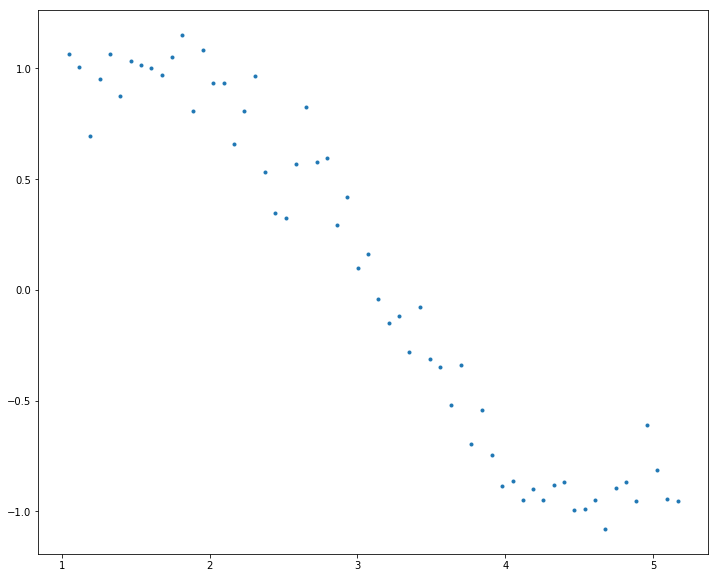

In [3]:
#Import libraries.
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

#Define input array with angles from 60deg to 300deg converted to radians
x = np.array([i*np.pi/180 for i in range(60,300,4)])
np.random.seed(10)  #Setting seed for reproducibility
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')

This resembles a sine curve but not exactly because of the noise. We’ll use this as an example to test different scenarios in this article. Lets try to estimate the sine function using polynomial regression with powers of x form 1 to 15. Lets add a column for each power upto 15 in our dataframe. This can be accomplished using the following code:

In [ ]:
for i in range(2,16):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data[colname] = data['x']**i
print data.head()

Now that we have all the 15 powers, lets make 15 different linear regression models with each model containing variables with powers of x from 1 to the particular model number. For example, the feature set of model 8 will be – {x, x_2, x_3, … ,x_8}.

First, we’ll define a generic function which takes in the required maximum power of x as an input and returns a list containing – [ model RSS, intercept, coef_x, coef_x2, … upto entered power ]. Here RSS refers to ‘Residual Sum of Squares’ which is nothing but the sum of square of errors between the predicted and actual values in the training data set. The python code defining the function is:

In [ ]:
#Import Linear Regression model from scikit-learn.
from sklearn.linear_model import LinearRegression
def linear_regression(data, power, models_to_plot):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for power: %d'%power)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

Note that this function will not plot the model fit for all the powers but will return the RSS and coefficients for all the models. I’ll skip the details of the code for now to maintain brevity. I’ll be happy to discuss the same through comments below if required.

Now, we can make all 15 models and compare the results. For ease of analysis, we’ll store all the results in a Pandas dataframe and plot 6 models to get an idea of the trend. Consider the following code:

In [ ]:
#Initialize a dataframe to store the results:
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

#Define the powers for which a plot is required:
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

#Iterate through all powers and assimilate results
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

We would expect the models with increasing complexity to better fit the data and result in lower RSS values. This can be verified by looking at the plots generated for 6 models.

This clearly aligns with our initial understanding. As the model complexity increases, the models tends to fit even smaller deviations in the training data set. Though this leads to overfitting, lets keep this issue aside for some time and come to our main objective, i.e. the impact on the magnitude of coefficients. This can be analysed by looking at the data frame created above.

In [ ]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

It is clearly evident that the size of coefficients increase exponentially with increase in model complexity. I hope this gives some intuition into why putting a constraint on the magnitude of coefficients can be a good idea to reduce model complexity.

Lets try to understand this even better.

What does a large coefficient signify? It means that we’re putting a lot of emphasis on that feature, i.e. the particular feature is a good predictor for the outcome. When it becomes too large, the algorithm starts modelling intricate relations to estimate the output and ends up overfitting to the particular training data.

I hope the concept is clear. I’ll be happy to discuss further in comments if needed. Now, lets understand ridge and lasso regression in detail and see how well they work for the same problem.

## Ridge Regression

As mentioned before, ridge regression performs ‘L2 regularization‘, i.e. it adds a factor of sum of squares of coefficients in the optimization objective. Thus, ridge regression optimizes the following:

Objective = RSS + α * (sum of square of coefficients)
Here, α (alpha) is the parameter which balances the amount of emphasis given to minimizing RSS vs minimizing sum of square of coefficients. α can take various values:

+ α = 0:
+ + The objective becomes same as simple linear regression. 
+ + We’ll get the same coefficients as simple linear regression.
+ α = ∞:
+ + The coefficients will be zero. Why? Because of infinite weightage on square of coefficients, anything less than zero will make the objective infinite.
+ 0 < α < ∞:
+ + The magnitude of α will decide the weightage given to different parts of objective.
+ + The coefficients will be somewhere between 0 and ones for simple linear regression.

I hope this gives some sense on how α would impact the magnitude of coefficients. One thing is for sure that any non-zero value would give values less than that of simple linear regression. By how much? We’ll find out soon. Leaving the mathematical details for later, lets see ridge regression in action on the same problem as above.

First, lets define a generic function for ridge regression similar to the one defined for simple linear regression. The Python code is:

In [ ]:
from sklearn.linear_model import Ridge
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

Note the ‘Ridge’ function used here. It takes ‘alpha’ as a parameter on initialization. Also, keep in mind that normalizing the inputs is generally a good idea in every type of regression and should be used in case of ridge regression as well.

Now, lets analyze the result of Ridge regression for 10 different values of α ranging from 1e-15 to 20. These values have been chosen so that we can easily analyze the trend with change in values of α. These would however differ from case to case.

Note that each of these 10 models will contain all the 15 variables and only the value of alpha would differ. This is different from the simple linear regression case where each model had a subset of features.

In [ ]:
#Initialize predictors to be set of 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

#Initialize the dataframe for storing coefficients.
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)

Here we can clearly observe that as the value of alpha increases, the model complexity reduces. Though higher values of alpha reduce overfitting, significantly high values can cause underfitting as well (eg. alpha = 5). Thus alpha should be chosen wisely. A widely accept technique is cross-validation, i.e. the value of alpha is iterated over a range of values and the one giving higher cross-validation score is chosen.

Lets have a look at the value of coefficients in the above models:

In [ ]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

This straight away gives us the following inferences:

1. The RSS increases with increase in alpha, this model complexity reduces
2. An alpha as small as 1e-15 gives us significant reduction in magnitude of coefficients. How? Compare the coefficients in the first row of this table to the last row of simple linear regression table.
3. High alpha values can lead to significant underfitting. Note the rapid increase in RSS for values of alpha greater than 1
4. Though the coefficients are very very small, they are NOT zero.

The first 3 are very intuitive. But #4 is also a crucial observation. Let’s reconfirm the same by determining the number of zeros in each row of the coefficients 

In [ ]:
coef_matrix_ridge.apply(lambda x: sum(x.values==0),axis=1)

This confirms that all the 15 coefficients are greater than zero in magnitude (can be +ve or -ve). Remember this observation and have a look again until its clear. This will play an important role in later while comparing ridge with lasso regression.

## Lasso Regression

LASSO stands for Least Absolute Shrinkage and Selection Operator. I know it doesn’t give much of an idea but there are 2 key words here – ‘absolute‘ and ‘selection‘.

Lets consider the former first and worry about the latter later.

Lasso regression performs L1 regularization, i.e. it adds a factor of sum of absolute value of coefficients in the optimization objective. Thus, lasso regression optimizes the following:

Objective = RSS + α * (sum of absolute value of coefficients)
Here, α (alpha) works similar to that of ridge and provides a trade-off between balancing RSS and magnitude of coefficients. Like that of ridge, α can take various values. Lets iterate it here briefly:

1. α = 0: Same coefficients as simple linear regression
2. α = ∞: All coefficients zero (same logic as before)
3. 0 < α < ∞: coefficients between 0 and that of simple linear regression

Yes its appearing to be very similar to Ridge till now. But just hang on with me and you’ll know the difference by the time we finish. Like before, lets run lasso regression on the same problem as above. 

First we’ll define a generic function:

In [ ]:
from sklearn.linear_model import Lasso
def lasso_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors],data['y'])
    y_pred = lassoreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

Notice the additional parameters defined in Lasso function – ‘max_iter‘. This is the maximum number of iterations for which we want the model to run if it doesn’t converge before. This exists for Ridge as as well but setting this to a higher than default value was required in this case. Why? I’ll come to this in next section, just keep it in the back of the envelope.

Lets check the output for 10 different values of alpha using the following code:

In [ ]:
#Initialize predictors to all 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Define the alpha values to test
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

#Initialize the dataframe to store coefficients
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

#Iterate over the 10 alpha values:
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(data, predictors, alpha_lasso[i], models_to_plot)

This again tells us that the model complexity decreases with increase in the values of alpha. But notice the straight line at alpha=1. Appears a bit strange to me. Let’s explore this further by looking at the coefficients.

Apart from the expected inference of higher RSS for higher alphas, we can see the following:

1. For the same values of alpha, the coefficients of lasso regression are much smaller as compared to that of ridge regression (compare row 1 of the 2 tables).
2. For the same alpha, lasso has higher RSS (poorer fit) as compared to ridge regression
3. Many of the coefficients are zero even for very small values of alpha

Inferences #1,2 might not generalize always but will hold for many cases. The real difference from ridge is coming out in the last inference. Lets check the number of coefficients which are zero in each model using following code:

In [ ]:
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)

We can observe that even for a small value of alpha, a significant number of coefficients are zero. This also explains the horizontal line fit for alpha=1 in the lasso plots, its just a baseline model! This phenomenon of most of the coefficients being zero is called ‘sparsity‘. Although lasso performs feature selection, this level of sparsity is achieved in special cases only which we’ll discuss towards the end.

This has some really interesting implications on the use cases of lasso regression as compared to that of ridge regression. But before coming to the final comparison, lets take a bird’s eye view of the mathematics behind why coefficients are zero in case of lasso but not ridge.